## Readmission prediction for heart failure patients
### Problem: 
Predict the readmission of heart failure patients within 30 days of discharge.

### Goal: 
Develop a machine learning model with high accuracy to identify at-risk patients, enabling targeted intervention.

### Approach:

1. **Data Preprocessing:** Clean specific medical identifiers and handle missing values.
2. **EDA:** Visualize distributions to understand patient demographics and vitals.
3. **Modeling:** Train 5 distinct models (Logistic Regression, SVM, Gradient Boosting, KNN, Decision Tree) separately to analyze individual performance.
4. **Optimization:** Use Voting Ensemble to combine model strengths.
5. **Deployment:** Save the best model

### 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc)
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

### 2. Data Loading

In [2]:
# Load the dataset
df = pd.read_csv('../data/heart_failure_dataset.csv')

print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (7039, 38)


,subject_id,admittime,dischtime,insurance,ethnicity,dob,dod,gender,age_at_admission,age_at_death,heart_rate,systolic_bp,diastolic_bp,respiratory_rate,spo2,temperature,albumin,hdl,ldl,cholesterol,troponin,creatinine,glucose,bun,hemoglobin,aspirin,beta_blockers,statins,diuretics,hadm_id,los,admission_type_EMERGENCY,admission_type_URGENT,admission_location_EMERGENCY ROOM ADMIT,admission_location_PHYS REFERRAL/NORMAL DELI,admission_location_TRANSFER FROM HOSP/EXTRAM,admission_location_TRANSFER FROM SKILLED NUR,readmission_30d
0,10006,23-10-2164 21:09,01-11-2164 17:15,Medicare,BLACK/AFRICAN AMERICAN,05-03-2094,12-08-2165,F,70,71,0.0,0.0,0.0,0.0,0.0,0.0,2.709091,100.475410,30.0,61.0,58.285714,5.417742,126.819672,22.245902,10.204688,1,0,0,0,142345,8.837500,True,False,True,False,False,False,0
1,10006,23-10-2164 21:09,01-11-2164 17:15,Medicare,BLACK/AFRICAN AMERICAN,05-03-2094,12-08-2165,F,70,71,0.0,0.0,0.0,0.0,0.0,0.0,2.709091,100.475410,30.0,61.0,58.285714,5.417742,126.819672,22.245902,10.204688,0,0,1,0,142345,8.837500,True,False,True,False,False,False,0
2,10011,14-08-2126 22:32,28-08-2126 18:59,Private,UNKNOWN/NOT SPECIFIED,05-06-2090,28-08-2126,F,36,36,0.0,0.0,0.0,0.0,0.0,0.0,2.450000,112.368421,0.0,0.0,0.000000,0.563158,115.526316,3.368421,11.231579,0,0,0,0,105331,13.852083,True,False,False,False,True,False,0
3,10013,04-10-2125 23:36,07-10-2125 15:13,Medicare,UNKNOWN/NOT SPECIFIED,03-09-2038,07-10-2125,F,87,87,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,99.000000,38.0,119.0,359.666667,1.700000,149.500000,32.000000,8.900000,1,0,0,0,165520,2.650694,True,False,False,False,True,False,0
4,10017,26-05-2149 17:19,03-06-2149 18:42,Medicare,WHITE,21-09-2075,12-09-2152,F,74,77,0.0,0.0,0.0,0.0,0.0,0.0,2.800000,101.866667,59.0,174.0,68.500000,0.440000,204.800000,7.533333,12.042857,0,0,1,0,199207,8.057639,True,False,True,False,False,False,0


### 3. Data Cleaning & Preprocessing

In [3]:
# 'los' and 'age' capture the necessary time/demographic info.
cols_to_drop = ['subject_id', 'hadm_id', 'admittime', 'dischtime', 'dob', 'dod']
df_clean = df.drop(columns=cols_to_drop, errors='ignore')

In [4]:
# Check missing values in each column
missing_vals = df_clean.isnull().sum()

print("Missing values per column:")
print(missing_vals)

Missing values per column:
insurance                                       0
ethnicity                                       0
gender                                          0
age_at_admission                                0
age_at_death                                    0
heart_rate                                      0
systolic_bp                                     0
diastolic_bp                                    0
respiratory_rate                                0
spo2                                            0
temperature                                     0
albumin                                         0
hdl                                             0
ldl                                             0
cholesterol                                     0
troponin                                        0
creatinine                                      0
glucose                                         0
bun                                             0
hemoglobin             

In [5]:
num_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df_clean.select_dtypes(include=['object', 'bool']).columns

In [6]:
# Encoding Categorical Variables
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    label_encoders[col] = le

In [7]:
# Drop Constant Columns 
non_constant_cols = [col for col in df_clean.columns if df_clean[col].nunique() > 1]
dropped_cols = set(df_clean.columns) - set(non_constant_cols)
df_clean = df_clean[non_constant_cols]

print(f"Dropped Constant Columns : {dropped_cols}")
print(f"Remaining Columns: {df_clean.shape[1]}")

Dropped Constant Columns : {'diuretics', 'beta_blockers'}
Remaining Columns: 30


### 4. Exploratory Data Analysis (EDA)

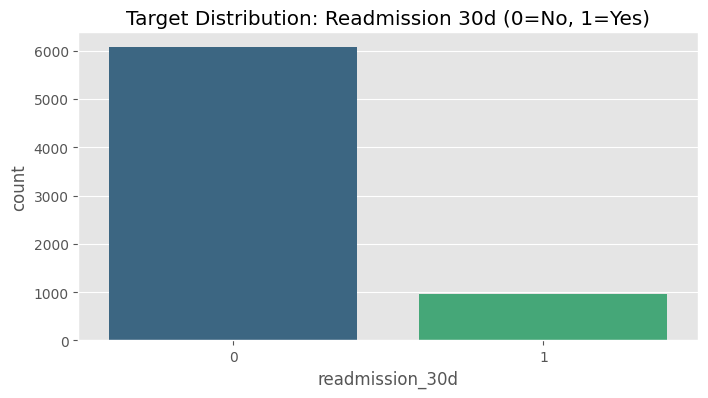

In [8]:
# Target Distribution
plt.figure(figsize=(8, 4))
sns.countplot(x='readmission_30d', data=df_clean, palette='viridis')
plt.title('Target Distribution: Readmission 30d (0=No, 1=Yes)')
plt.show()

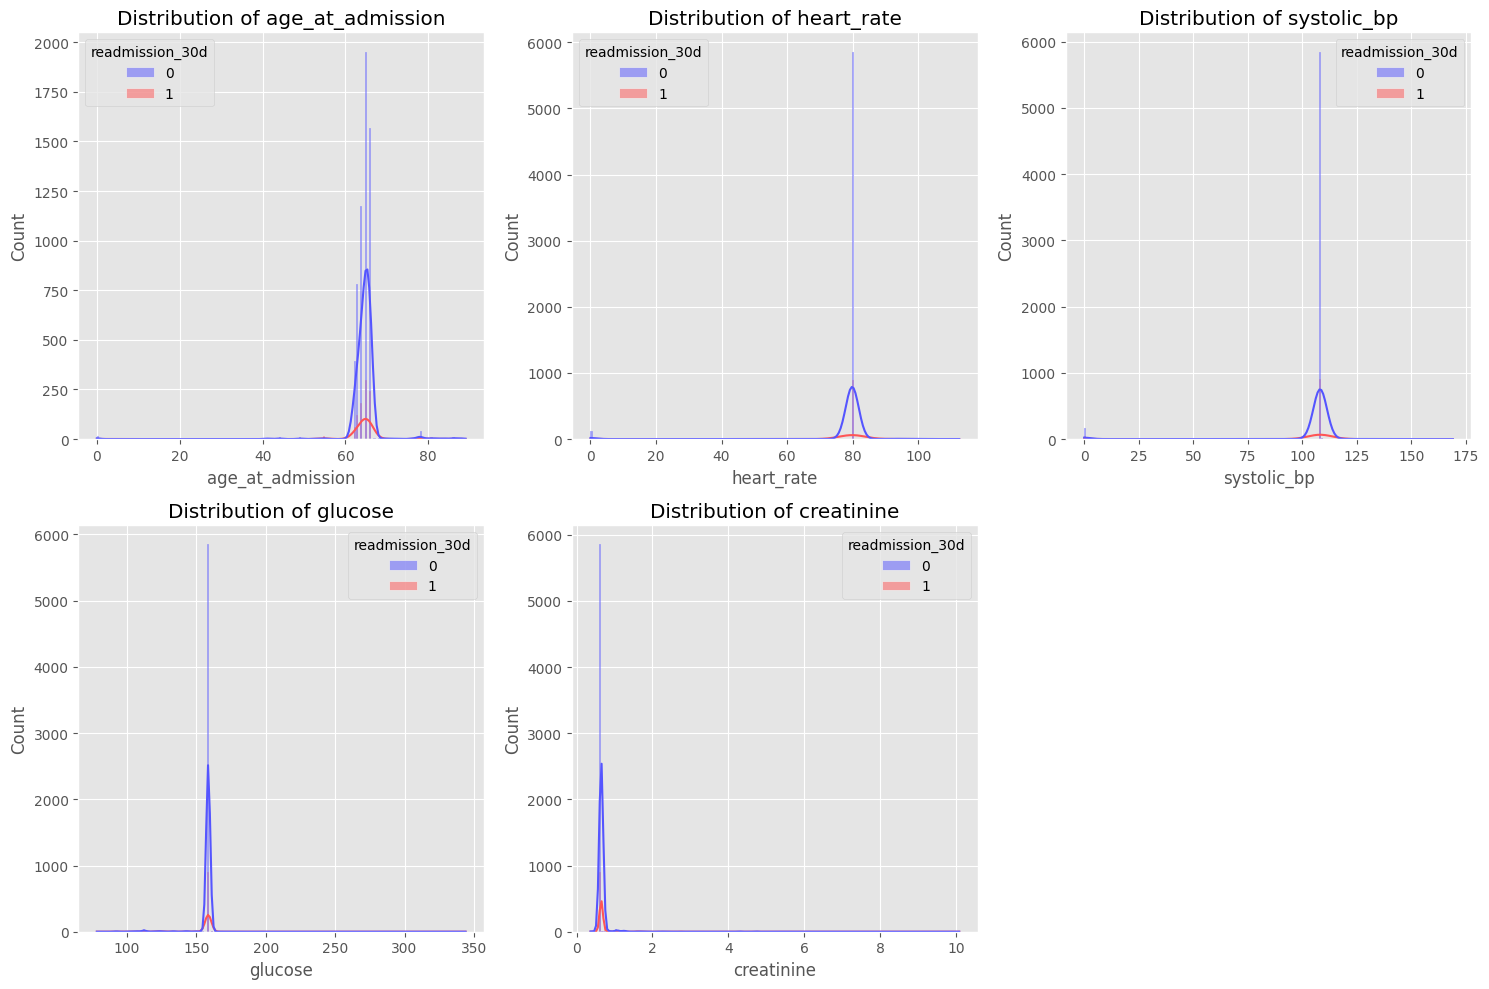

In [9]:
# Distribution of Key Numerical Features
features_to_plot = ['age_at_admission', 'heart_rate', 'systolic_bp', 'glucose', 'creatinine']
plt.figure(figsize=(15, 10))
for i, col in enumerate(features_to_plot):
    if col in df_clean.columns:
        plt.subplot(2, 3, i + 1)
        sns.histplot(data=df_clean, x=col, hue='readmission_30d', kde=True, palette='seismic')
        plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

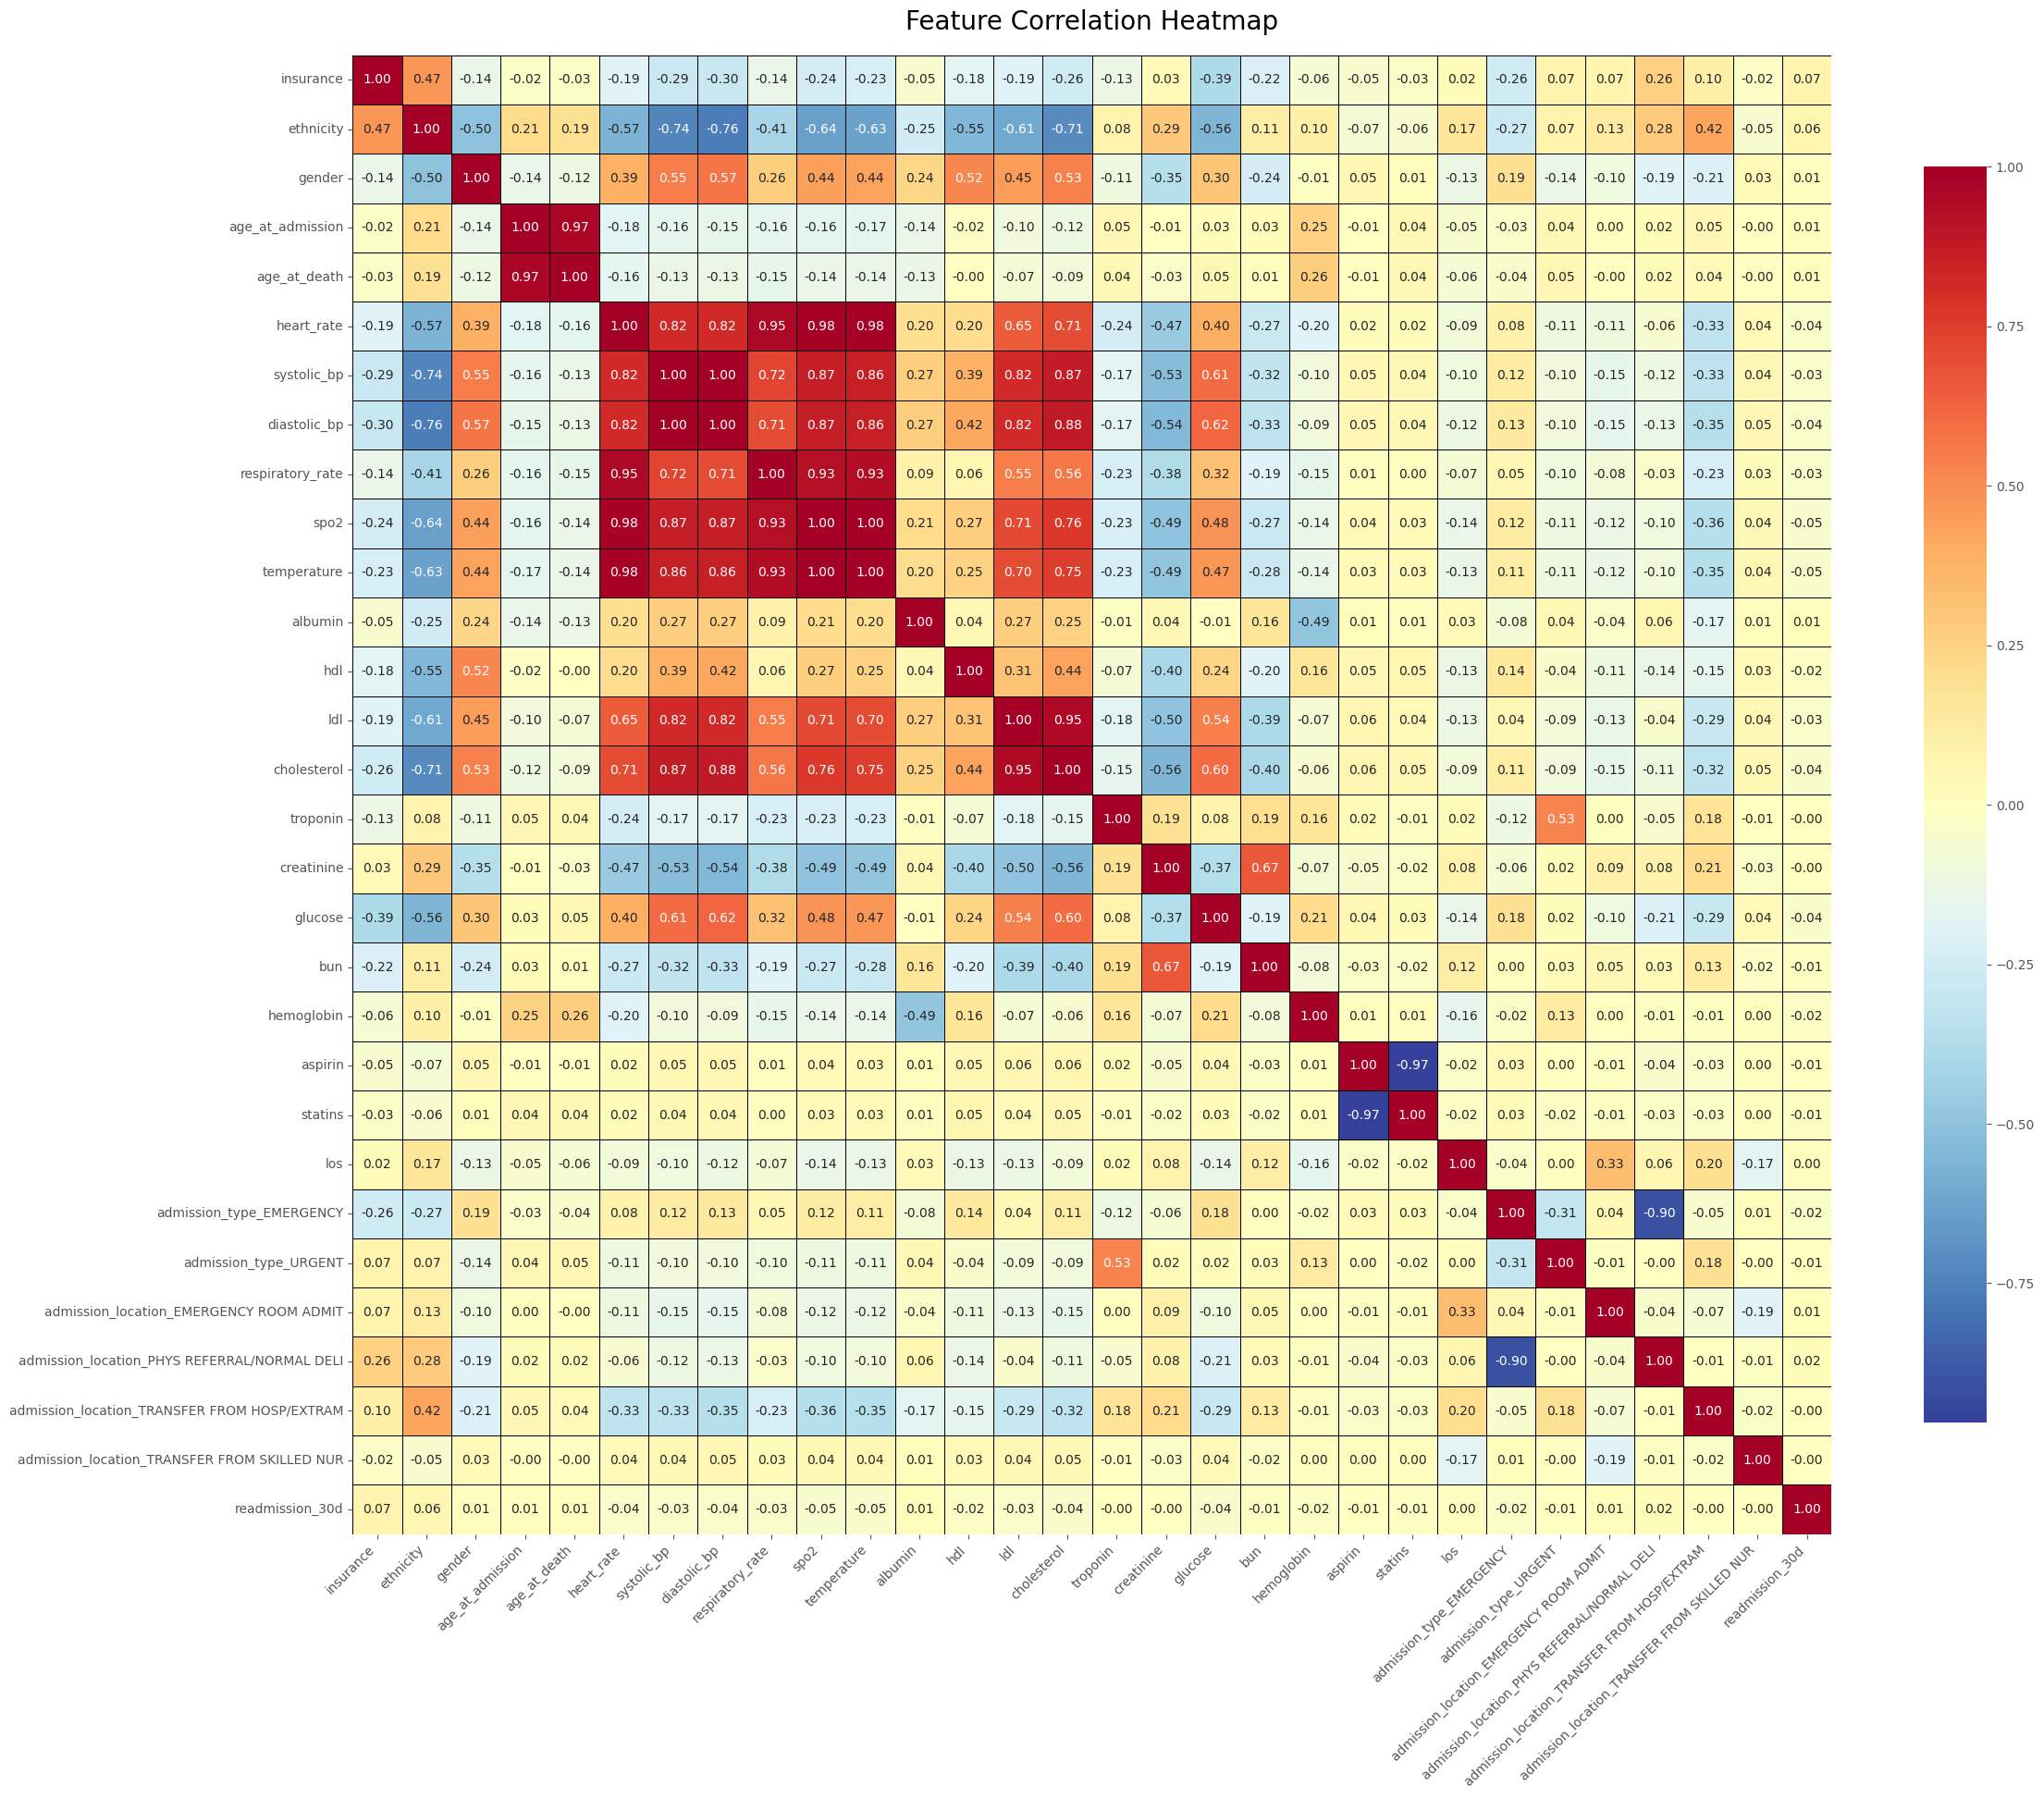

In [10]:
# Correlation Heatmap
plt.figure(figsize=(24, 20)) 
corr_matrix = df_clean.corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdYlBu_r', center=0, linewidths=0.5, linecolor='black', cbar_kws={"shrink": .8}, square=True)      
plt.title('Feature Correlation Heatmap', fontsize=20, pad=20)
plt.xticks(fontsize=10, rotation=45, ha='right') 
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

### 5. Model Building

In [11]:
X = df_clean.drop('readmission_30d', axis=1)
y = df_clean['readmission_30d']

In [12]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
# Apply SMOTE to handle class imbalance
print(f"Original Training Shape: {y_train.value_counts().to_dict()}")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"Resampled (SMOTE) Training Shape: {y_train_smote.value_counts().to_dict()}")

Original Training Shape: {0: 4860, 1: 771}
Resampled (SMOTE) Training Shape: {0: 4860, 1: 4860}


In [14]:
# Scaling (RobustScaler handles outliers better than StandardScaler)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

In [15]:
# Dictionary to store results for comparison
model_performance = {}

In [17]:
# Function to visualize confusion matrix
def plot_conf_matrix(y_true, y_pred, title):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix: {title}')
        plt.show()

## 6. Model Training

### Logistic Regression

In [18]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train_smote)
lr_pred = lr_model.predict(X_test_scaled)
lr_prob = lr_model.predict_proba(X_test_scaled)[:, 1]

              precision    recall  f1-score   support

           0       0.86      0.70      0.77      1215
           1       0.14      0.31      0.19       193

    accuracy                           0.65      1408
   macro avg       0.50      0.51      0.48      1408
weighted avg       0.77      0.65      0.69      1408



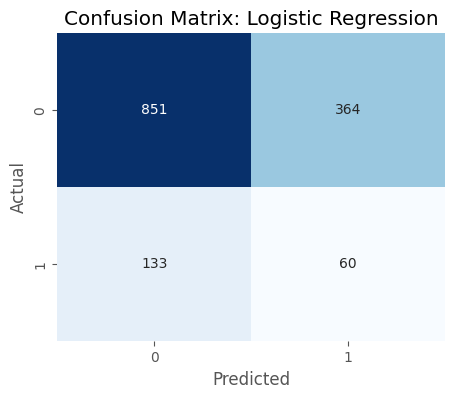

In [19]:
print(classification_report(y_test, lr_pred))
plot_conf_matrix(y_test, lr_pred, "Logistic Regression")
model_performance['Logistic Regression'] = {
    'model': lr_model, 'pred': lr_pred, 'prob': lr_prob, 
    'acc': accuracy_score(y_test, lr_pred), 'auc': roc_auc_score(y_test, lr_prob)
}

### Support Vector Machine (SVM)

In [20]:
svm_model = SVC(probability=True, random_state=42, kernel='rbf')
svm_model.fit(X_train_scaled, y_train_smote)
svm_pred = svm_model.predict(X_test_scaled)
svm_prob = svm_model.predict_proba(X_test_scaled)[:, 1]

              precision    recall  f1-score   support

           0       0.87      0.99      0.93      1215
           1       0.55      0.08      0.14       193

    accuracy                           0.87      1408
   macro avg       0.71      0.54      0.54      1408
weighted avg       0.83      0.87      0.82      1408



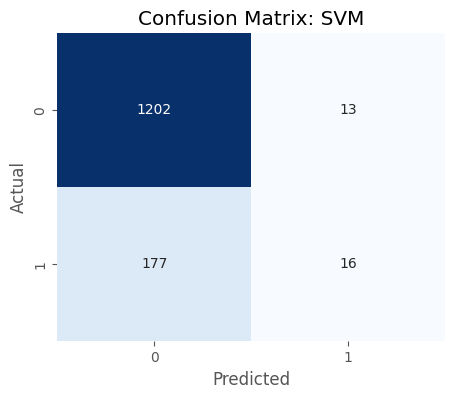

In [21]:
print(classification_report(y_test, svm_pred))
plot_conf_matrix(y_test, svm_pred, "SVM")
model_performance['SVM'] = {
    'model': svm_model, 'pred': svm_pred, 'prob': svm_prob, 
    'acc': accuracy_score(y_test, svm_pred), 'auc': roc_auc_score(y_test, svm_prob)
}

### Gradient Boosting

In [22]:
gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train_scaled, y_train_smote)
gb_pred = gb_model.predict(X_test_scaled)
gb_prob = gb_model.predict_proba(X_test_scaled)[:, 1]

              precision    recall  f1-score   support

           0       0.83      0.63      0.71      1215
           1       0.07      0.19      0.11       193

    accuracy                           0.57      1408
   macro avg       0.45      0.41      0.41      1408
weighted avg       0.73      0.57      0.63      1408



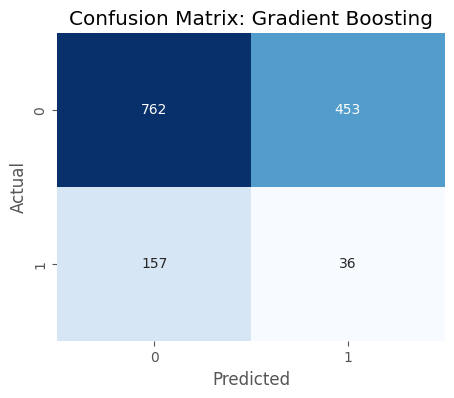

In [23]:
print(classification_report(y_test, gb_pred))
plot_conf_matrix(y_test, gb_pred, "Gradient Boosting")
model_performance['Gradient Boosting'] = {
    'model': gb_model, 'pred': gb_pred, 'prob': gb_prob, 
    'acc': accuracy_score(y_test, gb_pred), 'auc': roc_auc_score(y_test, gb_prob)
}

### K-Nearest Neighbors (KNN)

In [24]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train_smote)
knn_pred = knn_model.predict(X_test_scaled)
knn_prob = knn_model.predict_proba(X_test_scaled)[:, 1]

              precision    recall  f1-score   support

           0       0.87      0.99      0.92      1215
           1       0.47      0.07      0.13       193

    accuracy                           0.86      1408
   macro avg       0.67      0.53      0.53      1408
weighted avg       0.81      0.86      0.82      1408



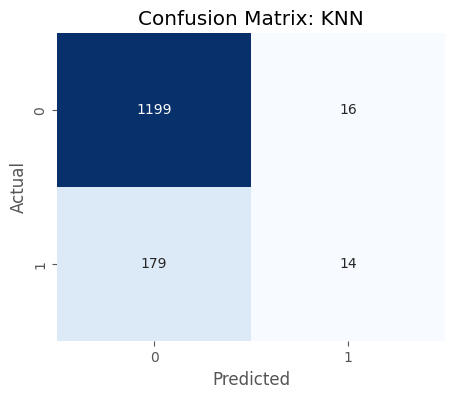

In [25]:
print(classification_report(y_test, knn_pred))
plot_conf_matrix(y_test, knn_pred, "KNN")
model_performance['KNN'] = {
    'model': knn_model, 'pred': knn_pred, 'prob': knn_prob, 
    'acc': accuracy_score(y_test, knn_pred), 'auc': roc_auc_score(y_test, knn_prob)
}

### Decision Tree

In [26]:
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(X_train_scaled, y_train_smote)
dt_pred = dt_model.predict(X_test_scaled)
dt_prob = dt_model.predict_proba(X_test_scaled)[:, 1]

              precision    recall  f1-score   support

           0       0.87      0.99      0.92      1215
           1       0.40      0.04      0.08       193

    accuracy                           0.86      1408
   macro avg       0.63      0.52      0.50      1408
weighted avg       0.80      0.86      0.81      1408



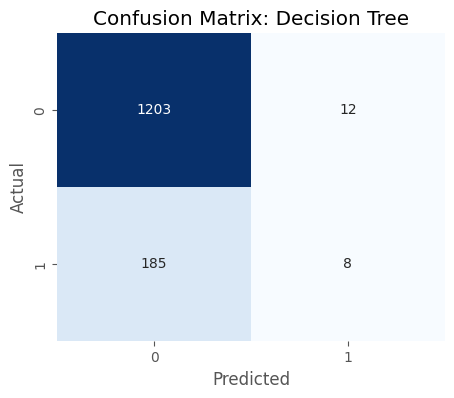

In [27]:
print(classification_report(y_test, dt_pred))
plot_conf_matrix(y_test, dt_pred, "Decision Tree")

model_performance['Decision Tree'] = {
    'model': dt_model, 'pred': dt_pred, 'prob': dt_prob,
    'acc': accuracy_score(y_test, dt_pred), 'auc': roc_auc_score(y_test, dt_prob)
}

### 7. Model Evaluation

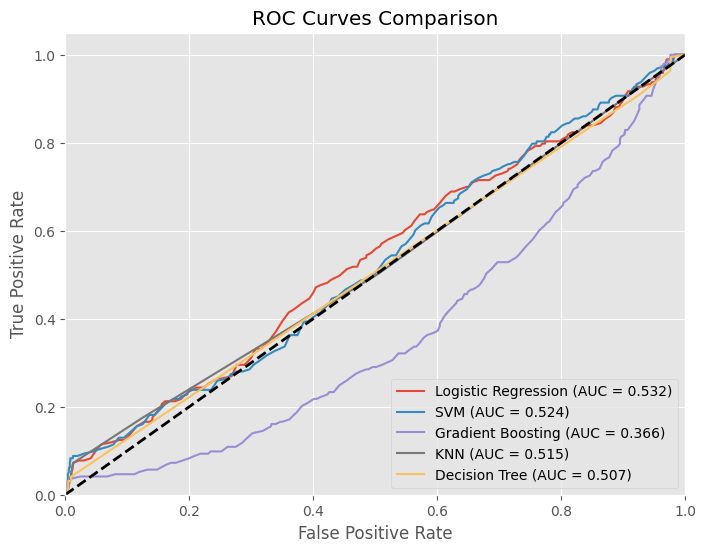

In [28]:
# Plot ROC Curves for all models
plt.figure(figsize=(8, 6))
for name, data in model_performance.items():
    fpr, tpr, _ = roc_curve(y_test, data['prob'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {data['auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")
plt.show()



### 8. Model Ensembling

In [29]:
voting_clf = VotingClassifier(
    estimators=[
        ('svm', svm_model),
        ('knn', knn_model),
        ('dt', dt_model)
    ],
    voting='soft' 
)

In [30]:
voting_clf.fit(X_train_scaled, y_train_smote)
voting_pred = voting_clf.predict(X_test_scaled)
voting_prob = voting_clf.predict_proba(X_test_scaled)[:, 1]
voting_acc = accuracy_score(y_test, voting_pred)
voting_auc = roc_auc_score(y_test, voting_prob)

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1215
           1       0.46      0.08      0.14       193

    accuracy                           0.86      1408
   macro avg       0.66      0.53      0.53      1408
weighted avg       0.81      0.86      0.82      1408



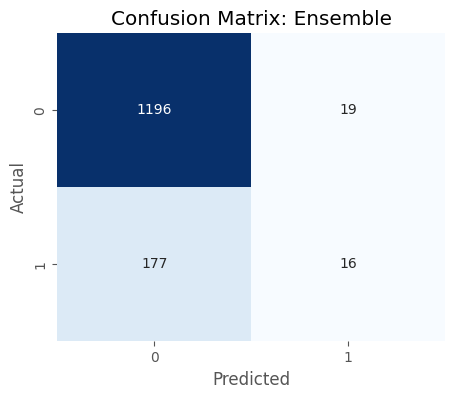

In [31]:
print(classification_report(y_test, voting_pred))
plot_conf_matrix(y_test, voting_pred, "Ensemble")

### 9. Feature Importance

In [32]:
importances = dt_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

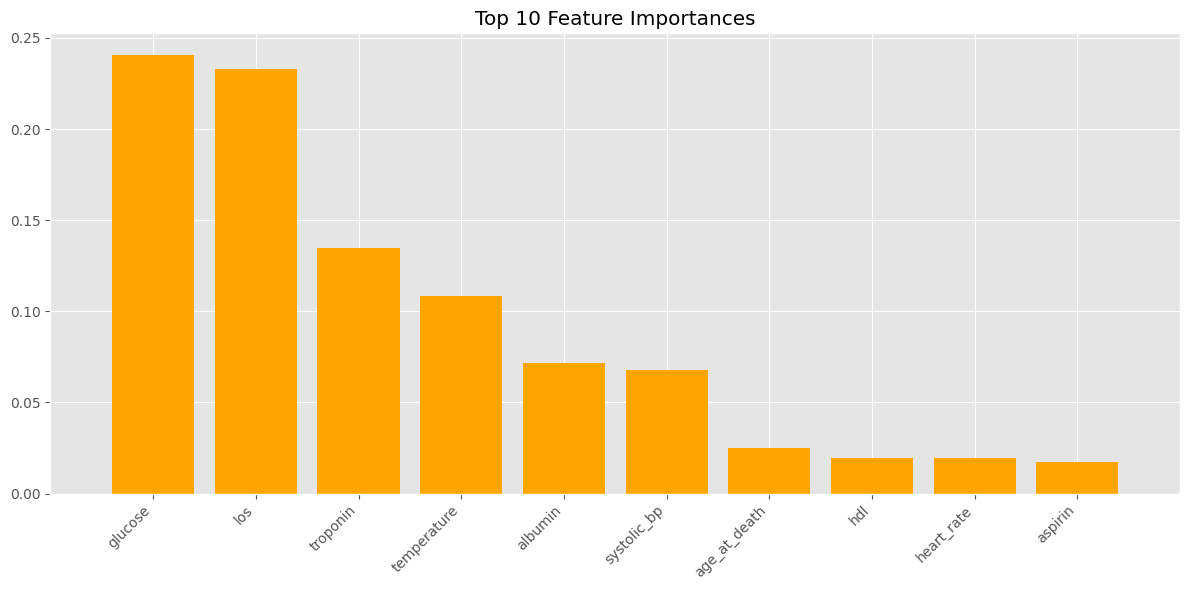

In [33]:
# Plot Top 10 Features
plt.figure(figsize=(12, 6))
plt.title("Top 10 Feature Importances")
plt.bar(range(10), importances[indices[:10]], align="center", color='orange')
plt.xticks(range(10), feature_names[indices[:10]], rotation=45, ha='right')
plt.xlim([-1, 10])
plt.tight_layout()
plt.show()

### 10. Model Saving

In [36]:
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

# Save the best performing model
model_path = os.path.join(models_dir, "best.pkl")
joblib.dump(voting_clf, model_path)
print(f"Model saved successfully at: {model_path}")

Model saved successfully at: ../models\best.pkl


In [37]:
# Save the scaler used during training
scaler_path = os.path.join(models_dir, "scaler.pkl")
joblib.dump(scaler, scaler_path)
print(f"Scaler saved successfully at: {scaler_path}")

Scaler saved successfully at: ../models\scaler.pkl


### Conclusion

#### 1. Exploratory Data Analysis & Preprocessing
- Performed exploratory analysis to understand feature distributions, correlations, and data quality.
- Resolved the *empty heatmap* issue by removing constant (zero-variance) features.
- Identified a significant class imbalance (approximately **86% vs 14%**) and addressed it using **SMOTE**, which led to a noticeable improvement in recall for the minority class.

#### 2. Model Training & Performance Evaluation
- Trained and evaluated individual models including **SVM, KNN, and Decision Tree**.
- Built a **soft-voting ensemble classifier** to combine the strengths of all three models and reduce prediction variance.
- The final ensemble model achieved:
  - **Accuracy:** 0.86  
  - **ROC-AUC Score:** 0.5247
- ROC curves were plotted using predicted probabilities to assess model performance across different thresholds.

#### 3. Feature Importance & Insights
- Feature importance analysis using the **Decision Tree model** provided interpretability and insight into model behavior.
- The most influential features contributing to readmission risk included:
  - **Glucose**
  - **Length of Stay (LOS)**
  - **Troponin**
- These features align well with clinical expectations, reinforcing the reliability of the model’s predictions.
